In [2]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3
import astropy.units as u

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

In [52]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
data = h5py.File(data_path, 'r')

gm_labels = {'fp':'FP', 'hm':'HM', 'sse':'SSE', 'elp':'ELCon'}

    
#dr = 0.025
#r_out = np.arange(0.15, 0.5 + dr, dr)
r_out = np.array([0.2, 0.3, 0.4, 0.5])
err_arr = np.zeros((r_out.size, 100))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

scenario = data['average']
scale = 1*u.AU.to(u.km)

r_path = "/".join(['cme_apex','r'])
obs = 'Observer 270.00'
gm = 'elp'
rg_path = "/".join(['observers', obs, gm, 'r_apex'])

r_int_limit = 0.5
sum_err = []
lines = []

ii=0
for r_key, run in scenario.items():

    # Get the HUXt and GM apex distances
    r = run[r_path][()]/scale
    rg = run[rg_path][()]/scale

    # Find only the valid values in each and compute the error and absolute error
    id_good = np.isfinite(r) & np.isfinite(rg)
    r = r[id_good]
    rg = rg[id_good]
    err = rg - r

    # interp at the out r vals and save
    err_arr[:, ii] = np.interp(r_out, r, err)
    ii += 1
    
    # Integrate the errors up to r_int_limit, save to array
    id_sub = r <= r_int_limit
    err_intg = np.trapz(err[id_sub], r[id_sub])
    sum_err.append(err_intg)

    # Update the plot with these data
    ax[0].plot(r, err, '-', color='darkgrey', zorder=1)
    h = ax[0].plot(r[id_sub], err[id_sub], '-', color='darkgrey', zorder=1)
    lines.append(h[0])

# Add integration limit to axes
ax[0].vlines(r_int_limit, -1, 1, colors='k', linestyles='dashed', linewidth=2)
ax[0].hlines(0, 0.1, 0.9, colors='k', linestyles='dotted', linewidth=2)

# Update line colors according to integrated error
sum_err = np.array(sum_err)

e_min = sum_err.min()
e_max = sum_err.max()
e_supermax = np.max([np.abs(e_min), e_max])
norm = mpl.colors.Normalize(vmin=-e_supermax, vmax=e_supermax)
cmap = mpl.cm.PiYG
for h, e in zip(lines, sum_err):
    h.set_color(cmap(norm(e)))

ylabel = "{} apex error, $\epsilon _{{{}}}$, (Au)".format(gm_labels[gm], gm_labels[gm])
ax[0].set_ylabel(ylabel)

ax[0].set_xlim(0.1, 0.9)
ax[0].set_ylim(-0.1, 0.25)
ax[0].set_xlabel('HUXt apex (Au)')

# Add histogram to last panel
bins = np.arange(-0.01, 0.02, 0.002)
ax[1].hist(sum_err, bins, density=True, color='skyblue')
# Add mean error
avg_err = np.mean(sum_err)
ax[1].vlines(0, 0, 400, colors='k', linestyles='-.', linewidth=2)
ax[1].vlines(avg_err, 0, 400, colors='r', linestyles='--', linewidth=2, label='$\\langle E_{{{}}} \\rangle$'.format(gm_labels[gm]))
ax[1].set_xlabel('Integrated {} apex error, $E_{{{}}}$'.format(gm_labels[gm], gm_labels[gm]))

# Format axes
ax[1].set_xlim(-0.0045, 0.019)
ax[1].set_ylim(0, 175)        
ax[1].set_ylabel('Density')    
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].legend()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.925, top=0.85, wspace=0.01)

# Add the colorbar to ax[0] for the errors
pos = ax[0].get_position()
dw = 0.005
dh = 0.005
left = pos.x0 + dw
bottom = pos.y1 + dh
wid = pos.width - 2 * dw
hi_cbaxes = fig.add_axes([left, bottom, wid, 0.02])
smp = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar1 = fig.colorbar(smp, cax=hi_cbaxes, orientation='horizontal')
cbar1.ax.set_xlabel('Integrated {} apex error, $E_{{{}}}$'.format(gm_labels[gm], gm_labels[gm]))
cbar1.ax.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

# save and close
proj_dirs = gmu.get_project_dirs()        
fig_name = "{}_integration_example_for_reviewers.png".format(err_type)
fig_path = os.path.join(proj_dirs['paper_figures'], fig_name)
fig.savefig(fig_path, format='png')
plt.close('all')

data.close()



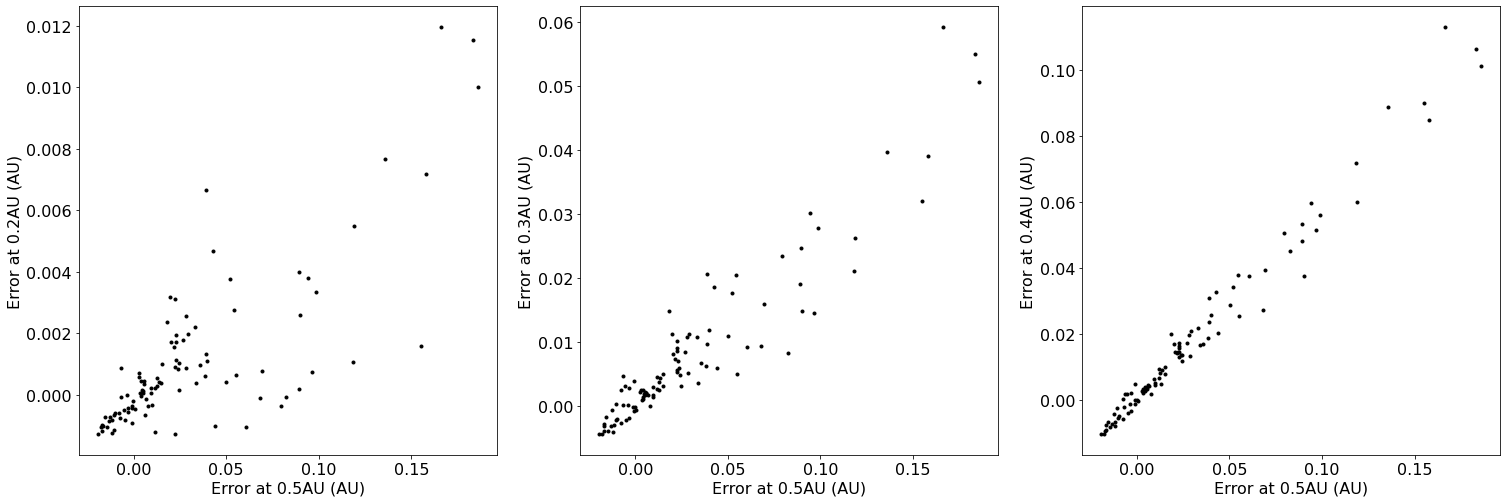

In [64]:

fig, ax = plt.subplots(1, 3, figsize=(21,7))
axr = ax.ravel()

#corr = np.zeros((err_arr.shape[0]-1))
for i in range(err_arr.shape[0]-1):
    axr[i].plot(err_arr[-1,:], err_arr[i,:], 'k.')
    
for a in axr:
    a.set_xlabel('Error at 0.5AU (AU)')
    
ax[0].set_ylabel('Error at 0.2AU (AU)')
ax[1].set_ylabel('Error at 0.3AU (AU)')
ax[2].set_ylabel('Error at 0.4AU (AU)')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2)

proj_dirs = gmu.get_project_dirs()        
fig_name = "error_correlation.png".format(err_type)
fig_path = os.path.join(proj_dirs['paper_figures'], fig_name)
fig.savefig(fig_path, format='png')
#plt.close('all')

In [47]:
ymaxs

[5.7748197903165565e-05,
 0.0036478539802932267,
 0.012642048226147036,
 0.02369549701486406,
 0.03600106619264249,
 0.04907998666716403,
 0.06250273139052544,
 0.07643497194895868,
 0.09069396033827926,
 0.10488519378293423,
 0.11948732564575817,
 0.13399882886597578,
 0.1522516603999073,
 0.17287190998124677,
 1.0,
 1.0]